In [1]:
DATASET='rec.mu2e.CRV_wideband_cosmics.CRVWB-000-003-000.root'

from mu2etools import *
from mu2etools import wideband
from scipy import stats

templist = [-9.4, -4.4, 0.4, 5.3, 10.3, 15.3, 20, 25, 30, 35, 40]
badchannels = [18, 29, 37, 38, 44, 58]
runlist = [
           [1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595],
           [1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582],
           [1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569],
           [1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556],    
           [1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542],  
           [1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525],
           [1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1493],
           [1433, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442],
           [1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451],
           [1457, 1458, 1459, 1460, 1461 ,1462, 1463, 1464, 1465],
           [1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506]   
          ]
        
        
bias = np.array([
                 [51.6, 52.1, 52.6, 53.1, 53.6, 54.1, 54.6, 55.1, 55.6],
                 [51.9, 52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9],
                 [52.2, 52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2],
                 [52.4, 52.9, 53.4, 53.9, 54.4, 54.9, 55.4, 55.9, 56.4],
                 [52.7, 53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7],
                 [53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0],
                 [53.2, 53.7, 54.2, 54.7, 55.2, 55.7, 56.2, 56.7, 57.2],
                 [53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5],
                 [53.8, 54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8],
                 [54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0],
                 [54.3, 54.8, 55.3, 55.8, 56.3, 56.8, 57.3, 57.8, 58.3]
                ])

In [2]:
def processTemperature(arr, idx):

    df = pd.DataFrame(columns=['chan', 'slope', 'temp', 'intercept', 'r_value', 'p_value', 'std_err', 
                               'Vbd', 'spe_3V_over', 'spe_54V_fix', 'spe_55V_fix', 'spe_60V_fix', 'spe_65V_fix'])

    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
    plt.subplots_adjust(wspace=0)
    fig.subplots_adjust(top=0.96)
    plt.suptitle("Temperature = %d C"%templist[idx])

    for hdmi, ax in enumerate(axs.flatten()):
        ax.set_xlabel("Set bias [V]")
        if(hdmi%4 == 0):
            ax.set_ylabel("PE")
        for inhdmi_chan in range(4):
            chan = hdmi*4+inhdmi_chan
            x=bias[idx]
            y=arSPE[:, 0, chan]
            mask = ~np.isnan(y)
            x=x[mask]
            y=y[mask]

            if y.size==0:
                print("Bad channel: %d"%(chan))
                continue

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            ratio = - intercept / slope
            ratio_stderr = ratio * np.sqrt((std_err / slope)**2)
            spe_3V_over = slope*(ratio + 3)+intercept

            new_row = {'chan': chan, 'slope': slope, 'temp': temp, 'intercept': intercept,
                       'r_value': r_value, 'p_value': p_value, 'std_err': ratio_stderr, 'Vbd': ratio, 
                       'spe_3V_over': spe_3V_over, 'spe_54V_fix': slope*54+intercept,
                       'spe_55V_fix': slope*55+intercept, 'spe_60V_fix': slope*60+intercept, 'spe_65V_fix': slope*65+intercept}
            df.loc[len(df)] = new_row

            markers = ax.plot(x, y, 'o', label='Chan: %d, SPE = %.1f+%.1fV, Vbd = %.2f'%(chan, intercept, slope, ratio))
            ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
            ax.legend(fontsize='small');
    return df

Bad channel: 38
Bad channel: 38
Bad channel: 58


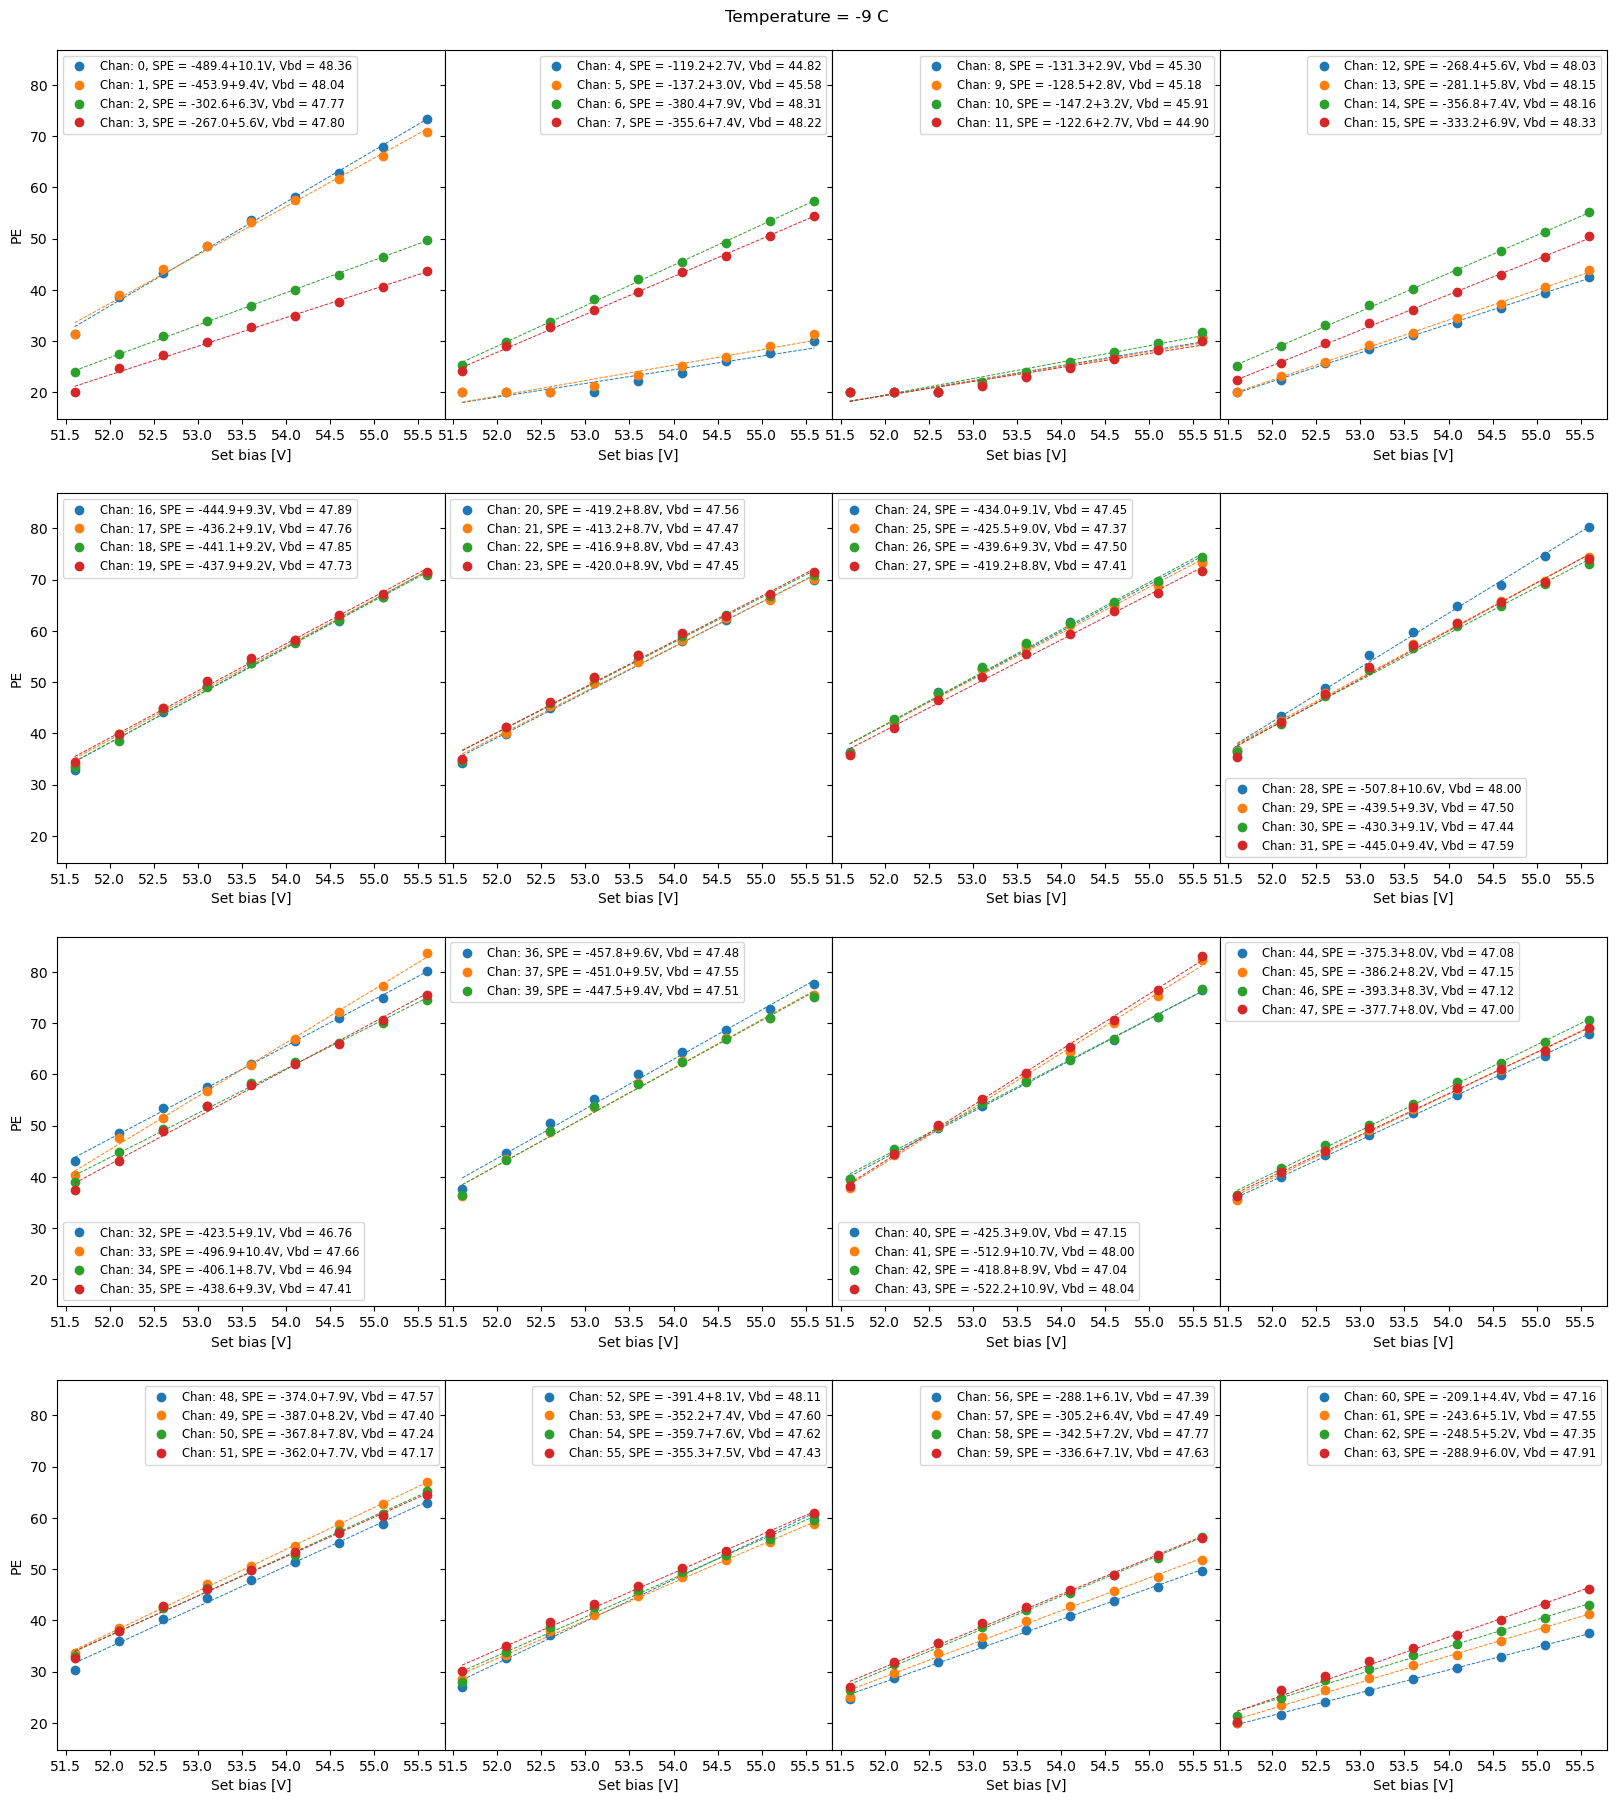

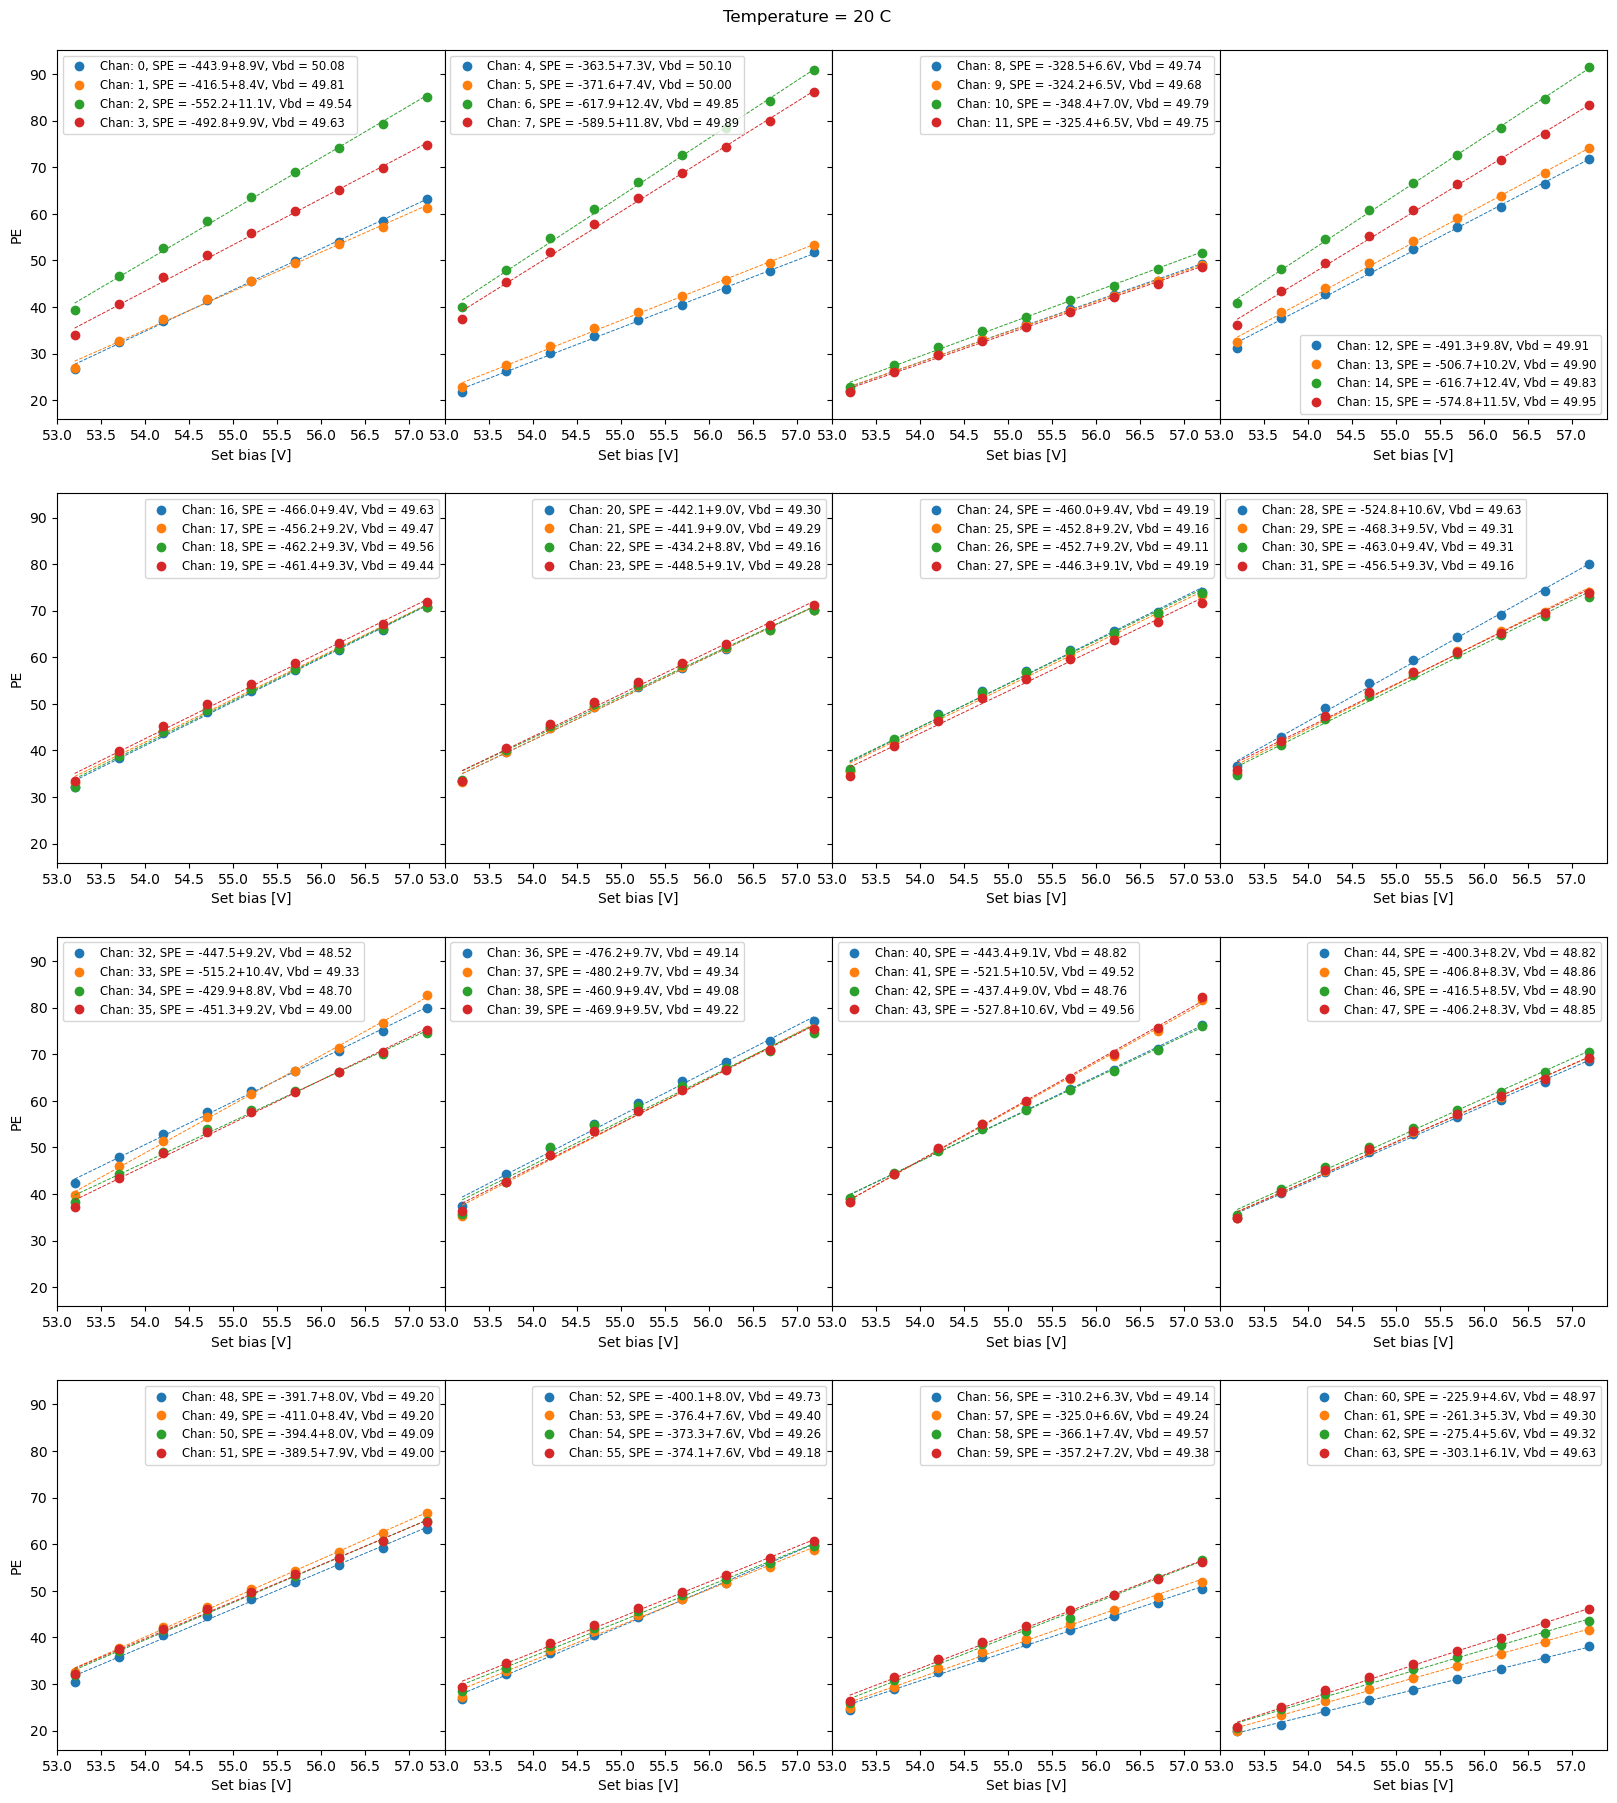

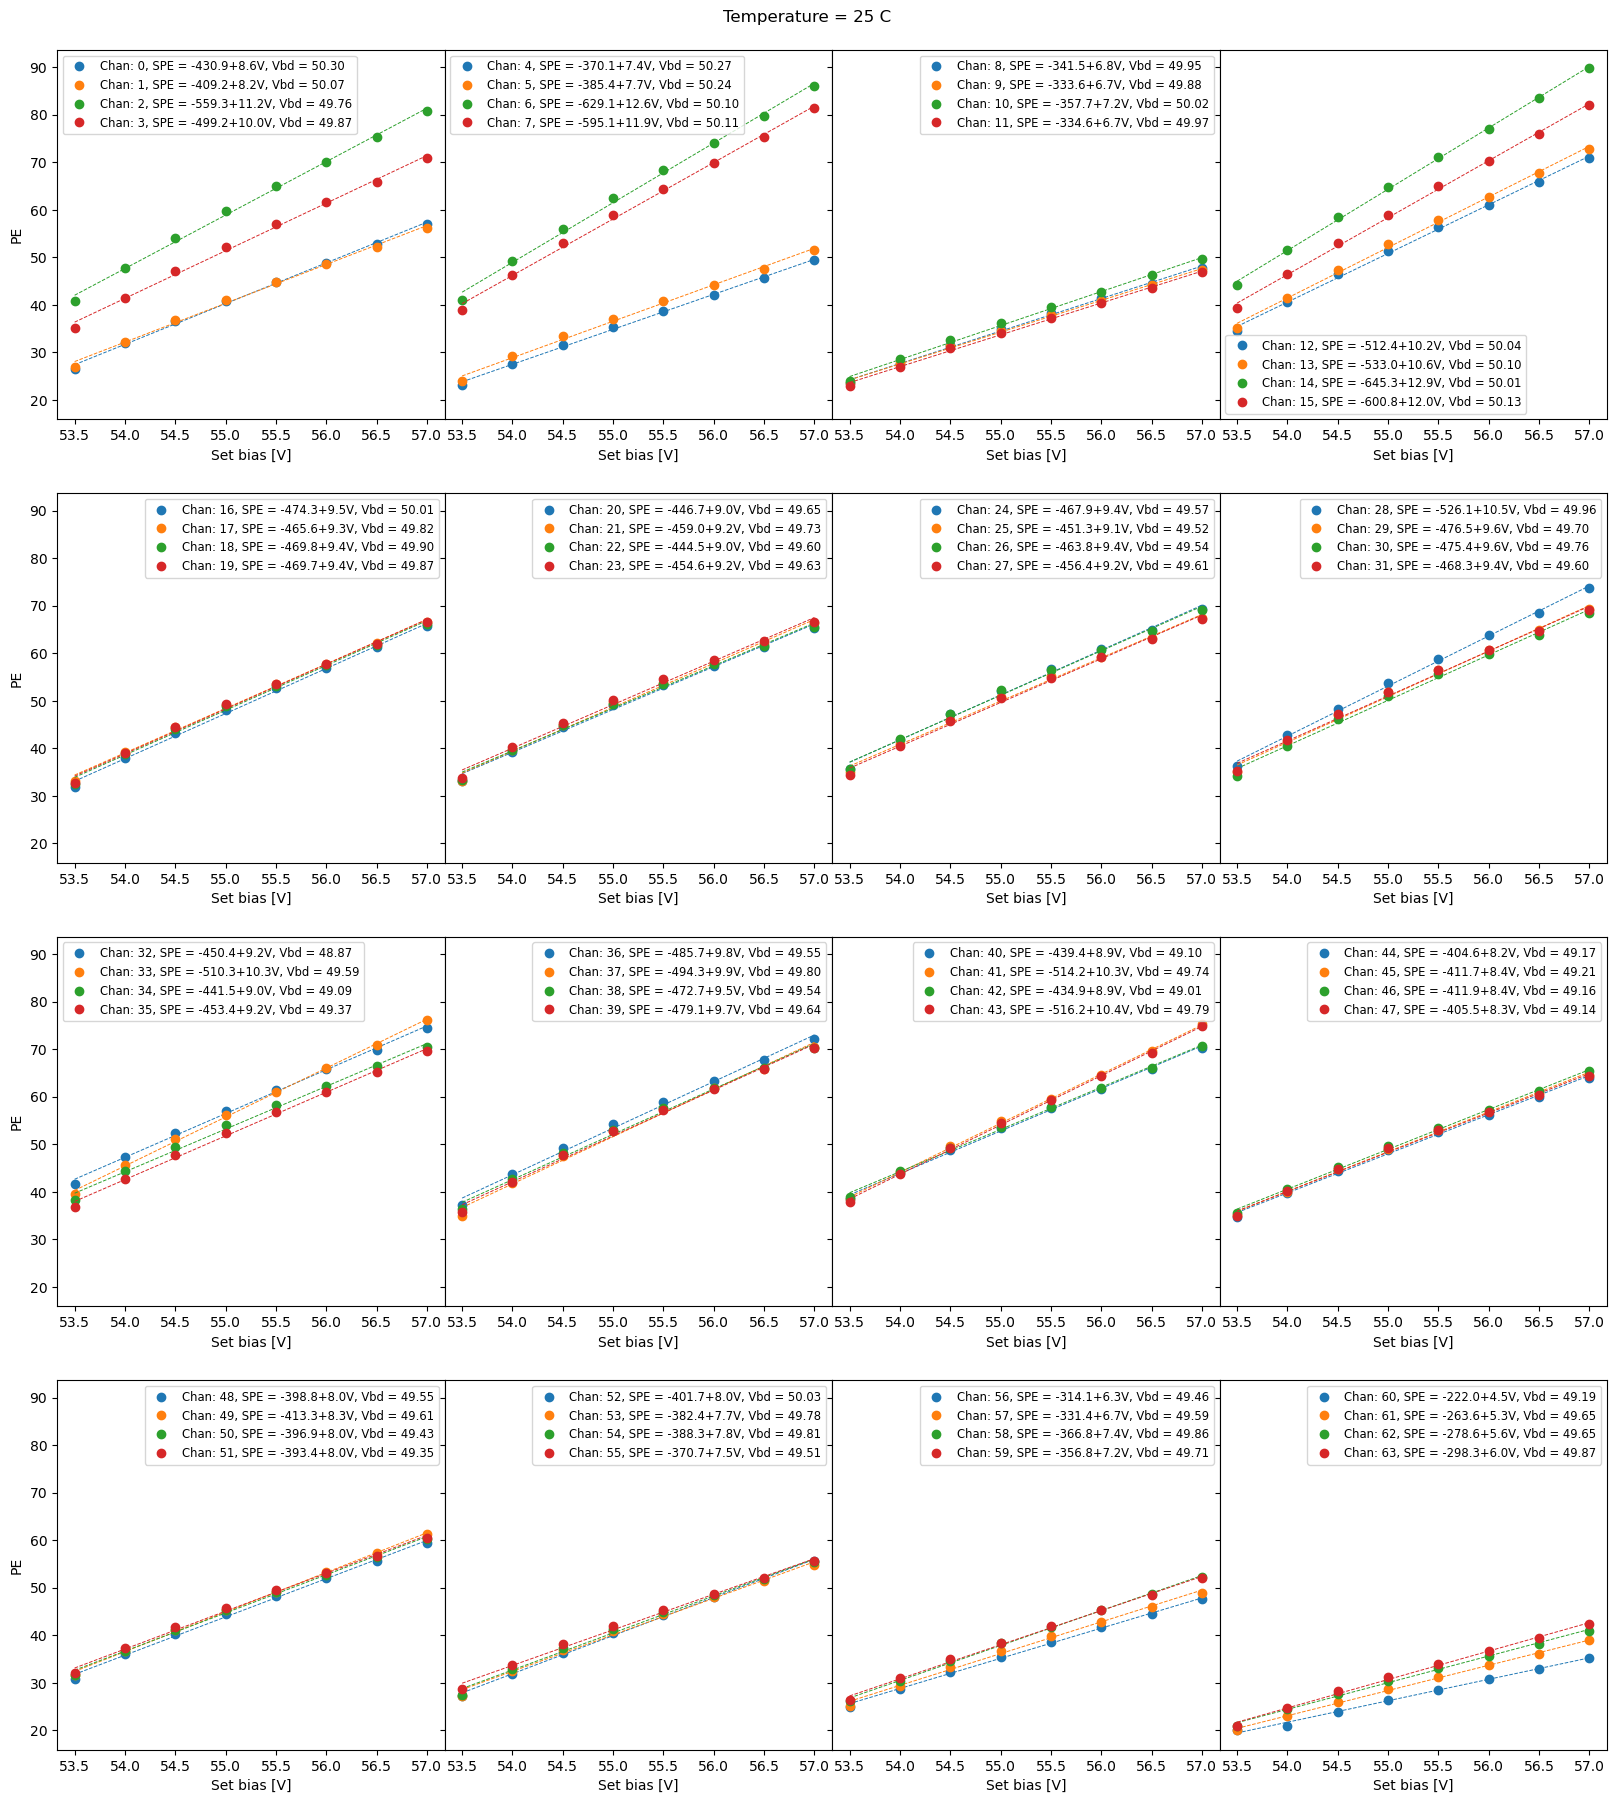

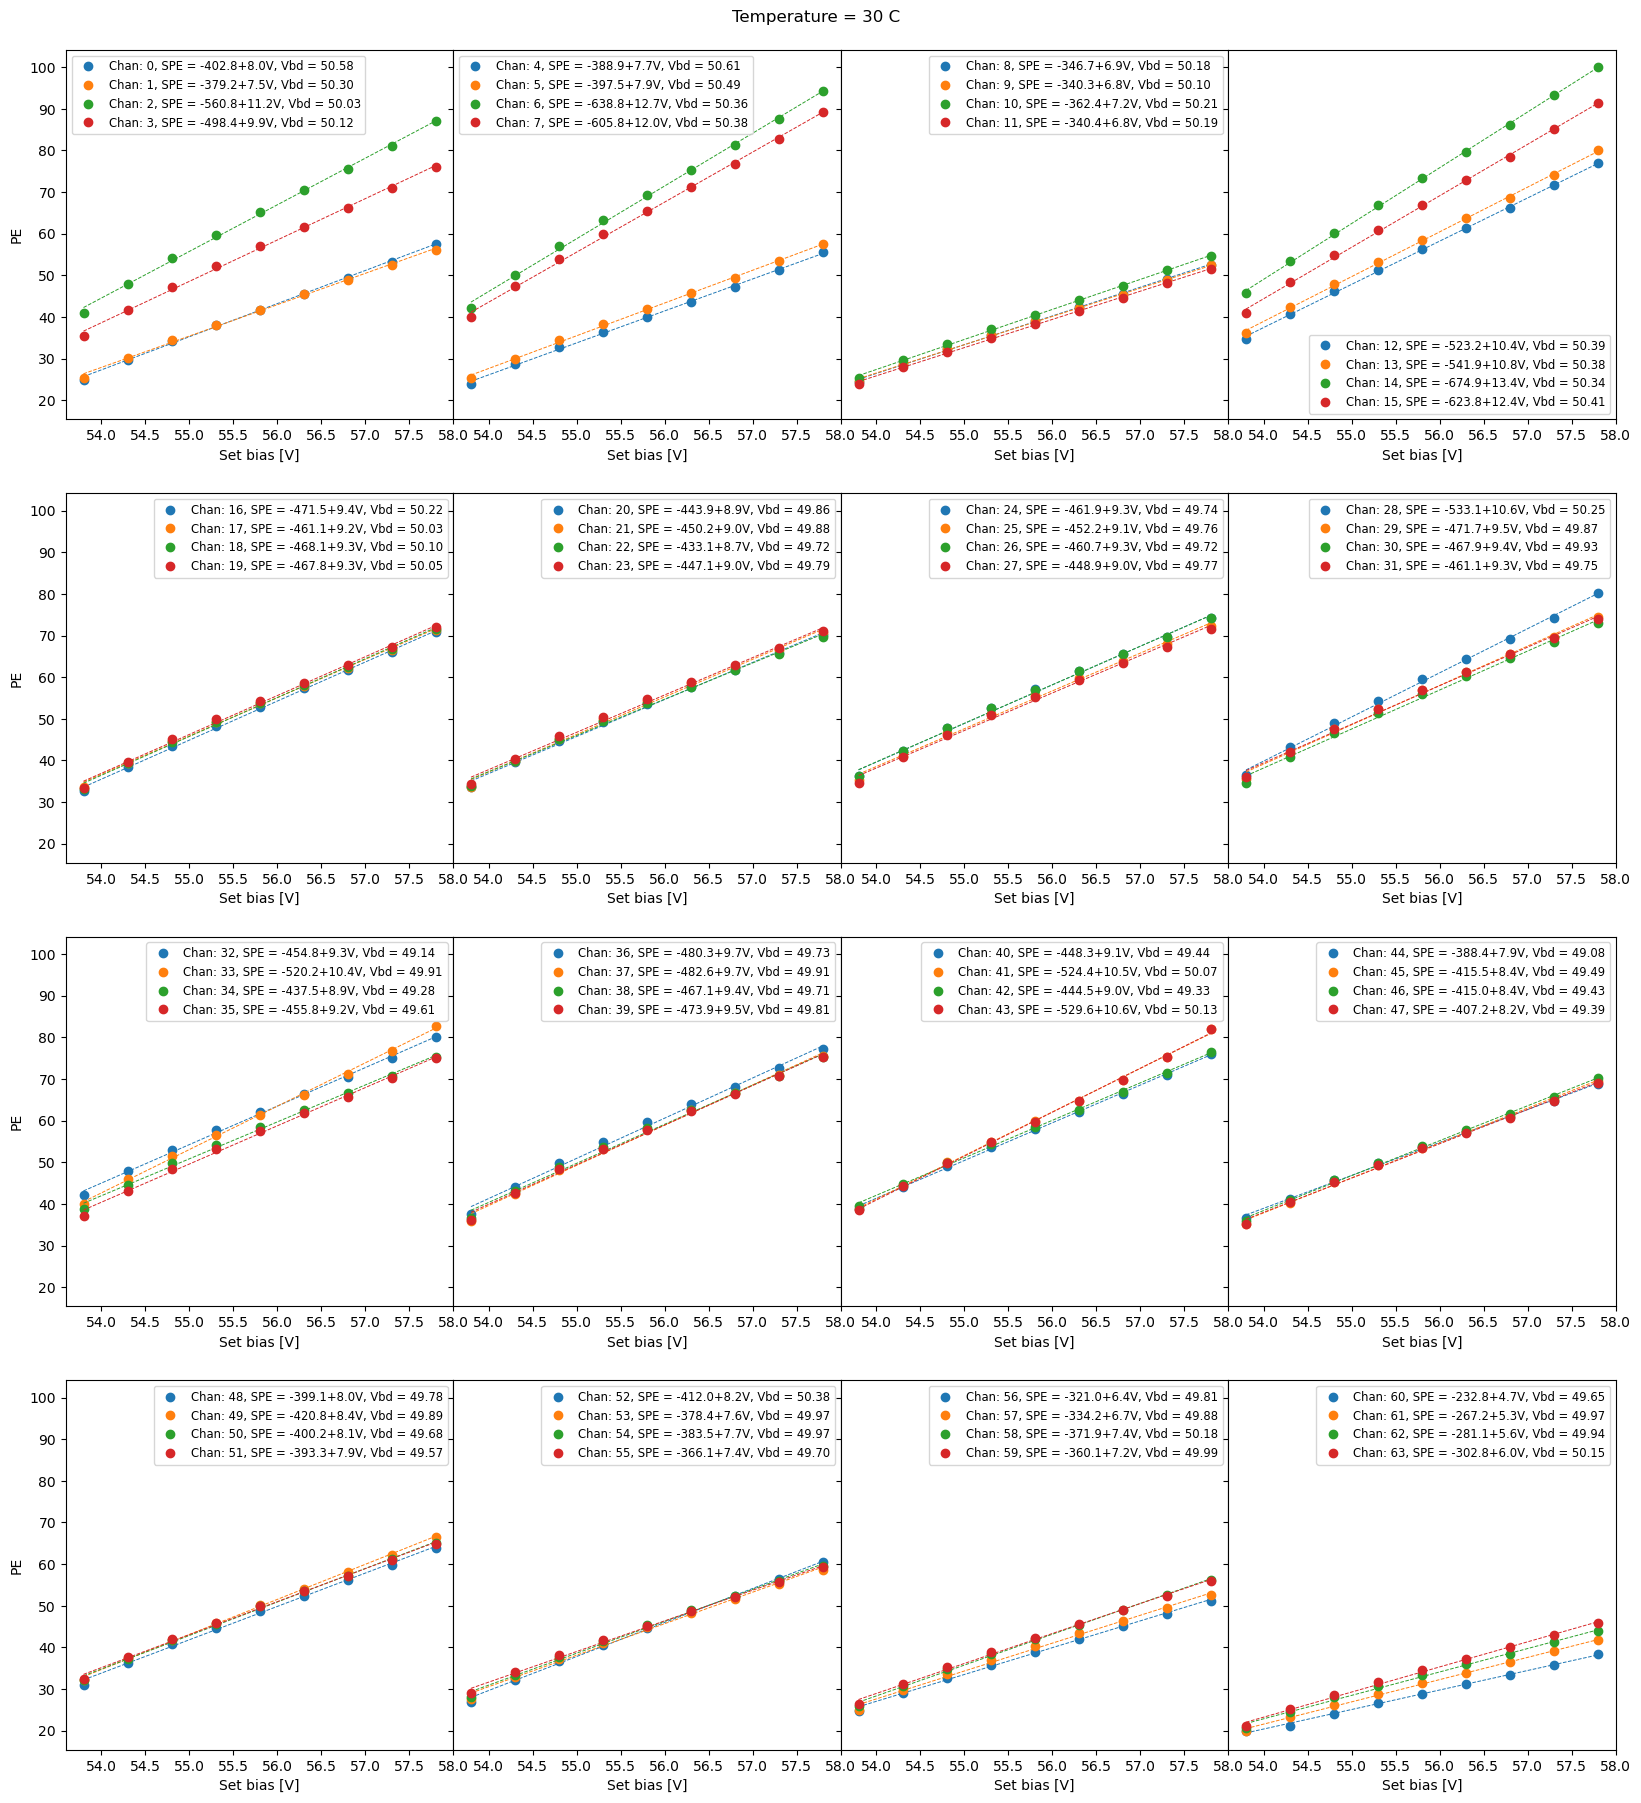

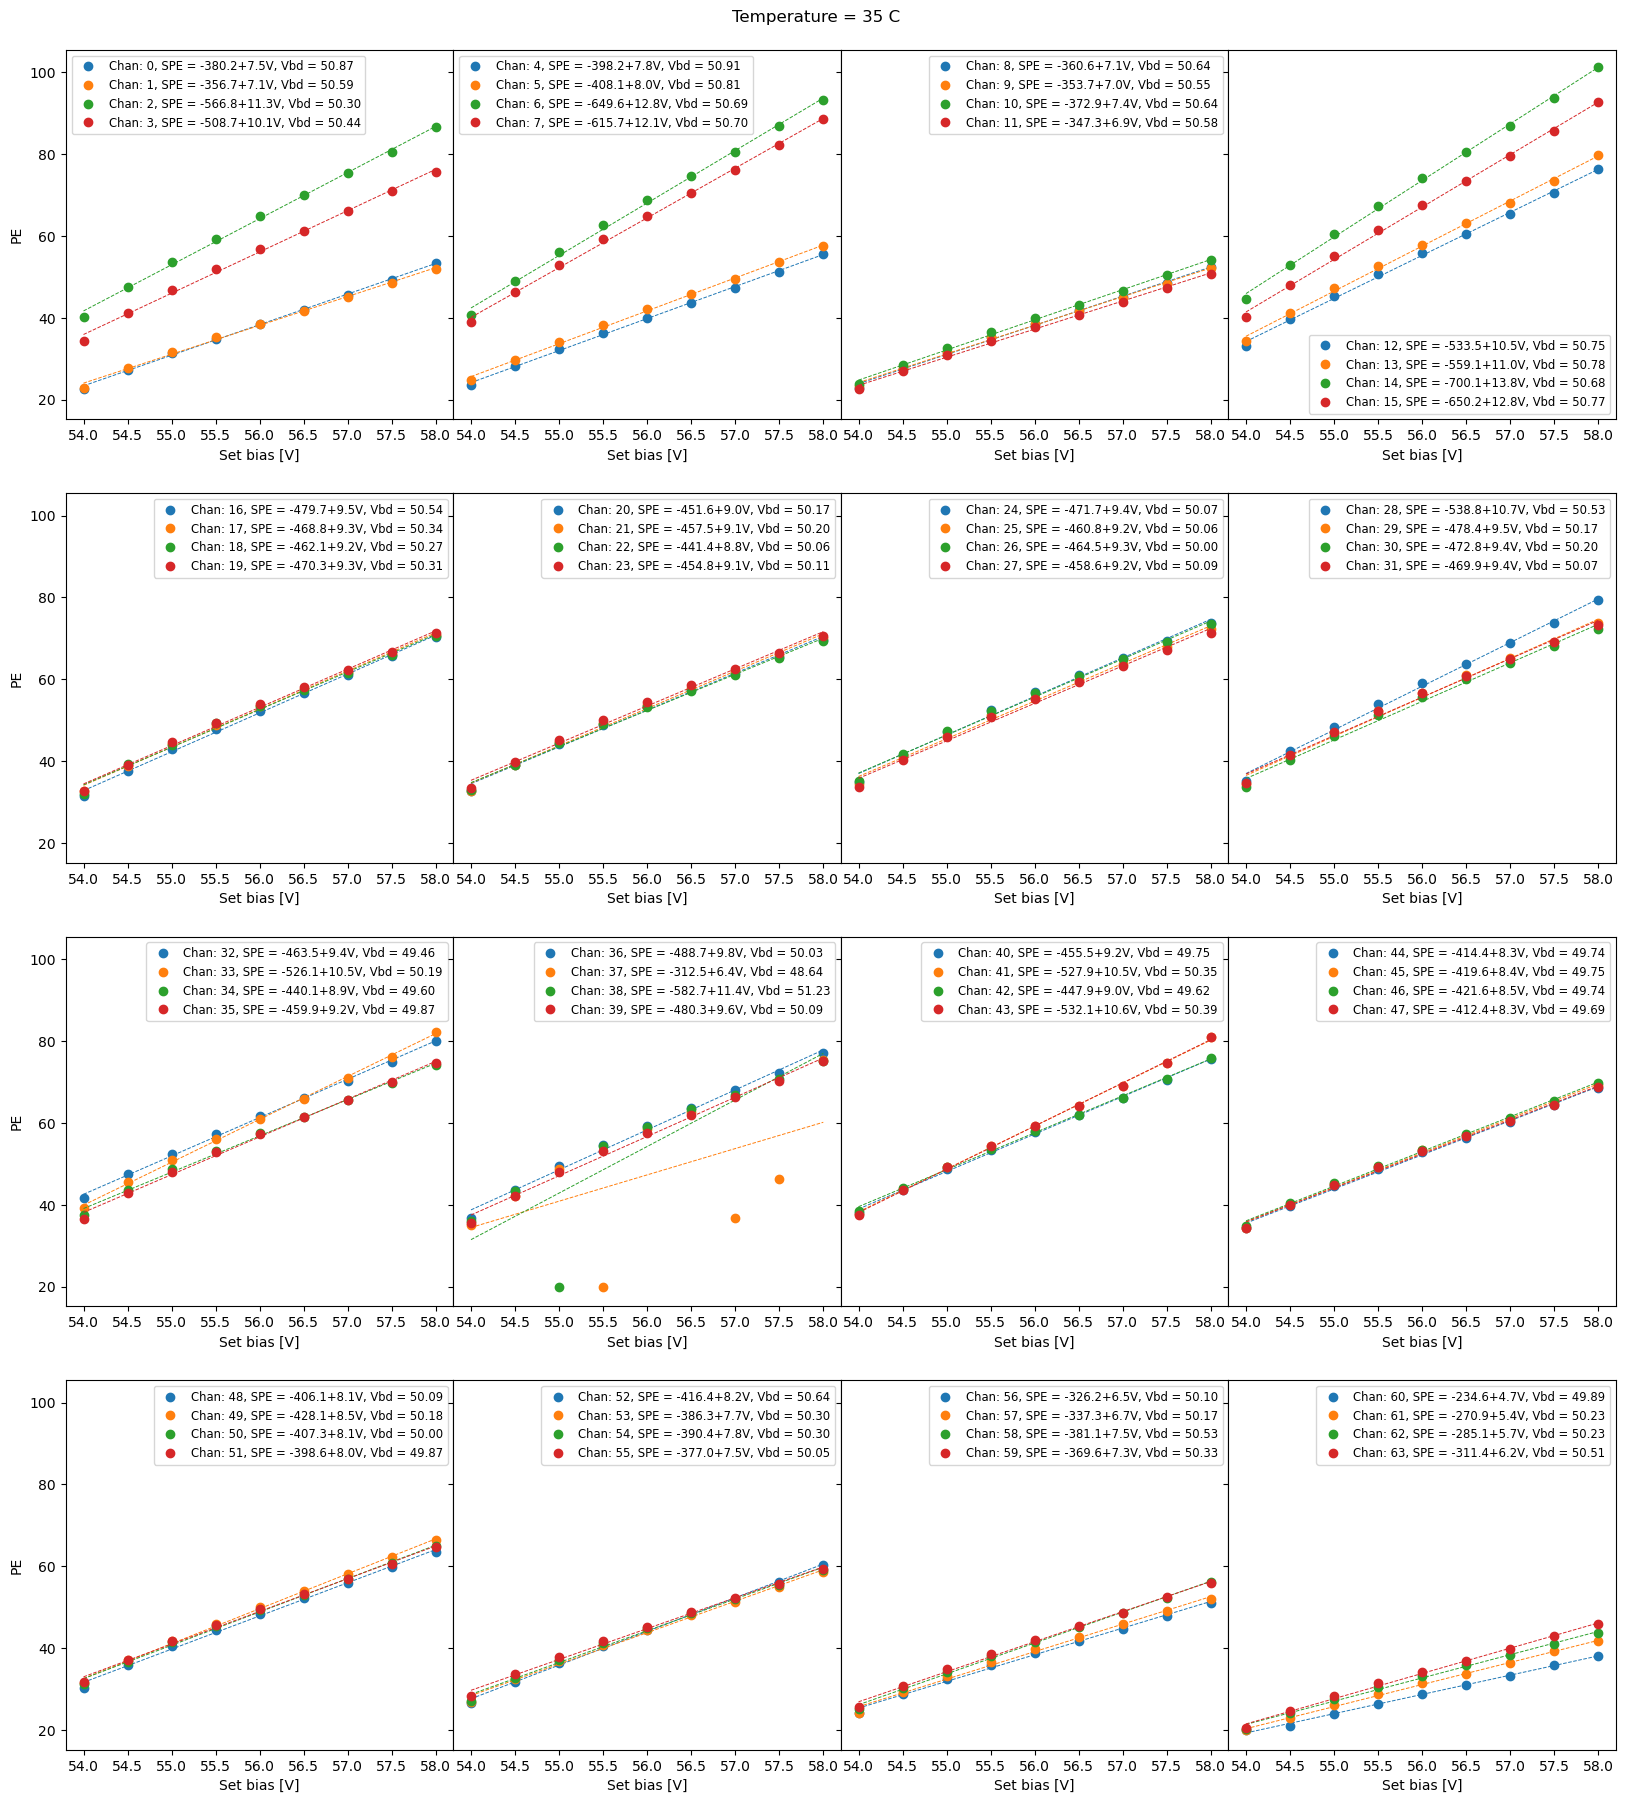

In [3]:
df = pd.DataFrame()

for idx, temp in enumerate(templist):
    processor = wideband.DataProcessor(usexroot=True, fixtimes=False, runlist=runlist[idx], userunlist=True, remove=False)
    arr, arSpills = processor.getData(DATASET) # get akward array for "runSummary" tree
    
    if not np.array_equal(np.array(runlist[idx]), arr['runNumber'].to_numpy()):
        print("Input run list order and data do not match")
    
    #Mask channels which were not calibrated
    var = 'PEs'    
    arSPE = ak.mask(arr[var], arr[var]>0).to_numpy()
    
    df_tmp = processTemperature(arSPE, idx)
    df = pd.concat([df, df_tmp], ignore_index=True)

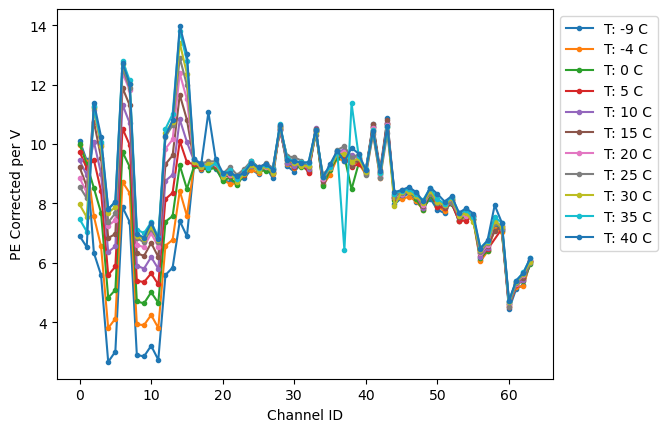

In [4]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['slope'], '.-', label=('T: %d C'%temp))
plt.xlabel("Channel ID")
plt.ylabel("PE Corrected per V");
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

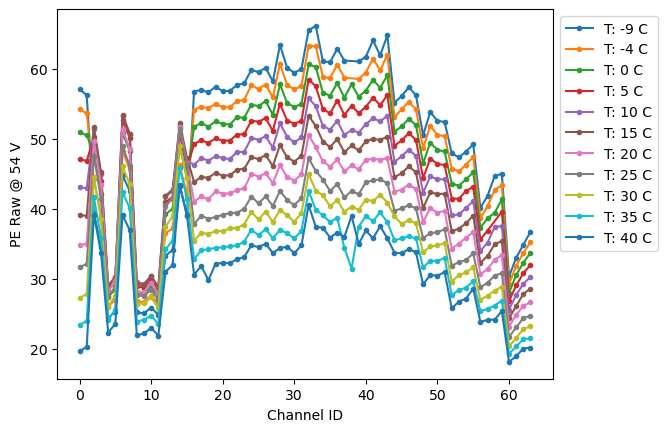

In [9]:
for temp in templist:
    plt.plot(df.query('temp == %f'%temp)['chan'], df.query('temp == %f'%temp)['spe_54V_fix'], '.-', label=('T: %d C'%temp))
plt.xlabel("Channel ID")
plt.ylabel("PE Raw @ 54 V");
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0));

In [6]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

dfSPE_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])


for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("PE at 54V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in badchannels:
            continue
            
        x = df.query('chan==%d'%chan)['temp']
        y = df.query('chan==%d'%chan)['spe_54V_fix'].to_numpy()
        y=y/y[7]

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, PE/C = %.2f+(%.3f +/- %.3f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        dfSPE_Temp.loc[len(dfSPE_Temp)] = new_row

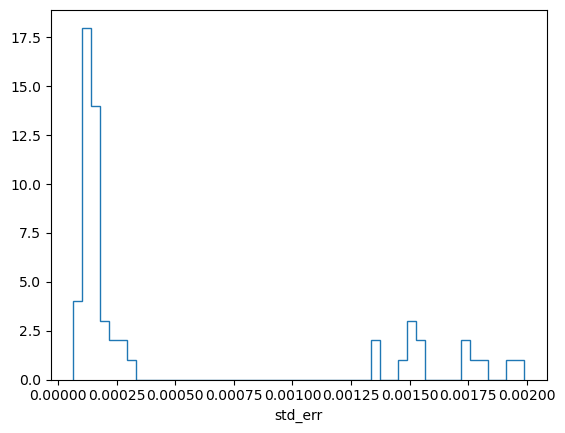

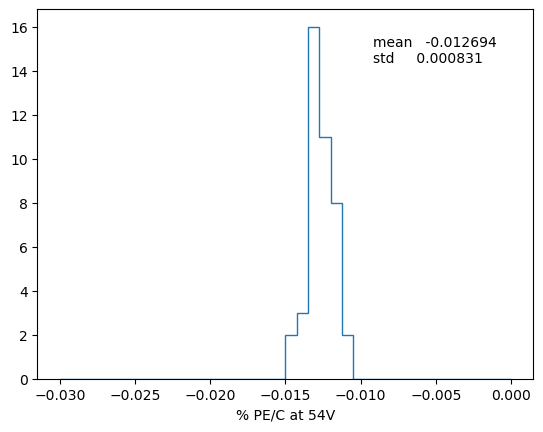

In [7]:
plt.hist(dfSPE_Temp['std_err'], histtype='step', bins=50);
plt.xlabel('std_err')
plt.figure()
plt.hist(dfSPE_Temp.query('std_err<0.3 & chan > 15')['slope'], histtype='step', bins=40, range=(-0.03,0));
plt.xlabel('% PE/C at 54V');
plt.figtext(0.65,0.77, dfSPE_Temp.query('std_err<0.3 & chan > 15')['slope'].describe().loc[['mean','std']].to_string());

In [8]:
pd.set_option('display.max_rows', None)
df

chan      slope  temp   intercept   r_value       p_value    std_err  \
0       0  10.120115  -9.4 -489.370308  0.998783  2.070151e-10   0.902664   
1       1   9.446931  -9.4 -453.871054  0.996904  5.417524e-09   1.432139   
2       2   6.333776  -9.4 -302.559852  0.999670  2.157168e-12   0.464216   
3       3   5.585881  -9.4 -267.029854  0.997067  4.485770e-09   1.386882   
4       4   2.659929  -9.4 -119.207248  0.945949  1.146304e-04   5.807413   
5       5   3.009584  -9.4 -137.182921  0.967887  1.893645e-05   4.474689   
6       6   7.874821  -9.4 -380.429610  0.999498  9.307550e-12   0.578600   
7       7   7.373936  -9.4 -355.590670  0.999186  5.058008e-11   0.735762   
8       8   2.899108  -9.4 -131.326349  0.972666  1.082419e-05   4.087450   
9       9   2.843617  -9.4 -128.460716  0.971021  1.325887e-05   4.202479   
10     10   3.205119  -9.4 -147.162841  0.977853  5.209241e-06   3.714406   
11     11   2.731114  -9.4 -122.615751  0.969714  1.545321e-05   4.274007   
12     12   5.587781  -9.4 -268.405654  0.999553  6.208337e-12   0.542942   
13     13   5.838314  -9.4 -281.142120  0.999385  1.893484e-11   0.638393   
14     14   7.407822  -9.4 -356.784347  0.999574  5.238147e-12   0.531332   
15     15   6.893757  -9.4 -333.206825  0.999280  3.290521e-11   0.693481   
16     16   9.290230  -9.4 -444.898669  0.998325  6.324087e-10   1.048989   
17     17   9.134198  -9.4 -436.225318  0.998753  2.251096e-10   0.902246   
18     18   9.217758  -9.4 -441.110880  0.998557  3.753726e-10   0.972762   
19     19   9.173853  -9.4 -437.903090  0.998436  4.977102e-10   1.010321   
20     20   8.814592  -9.4 -419.180901  0.997747  1.783692e-09   1.208623   
21     21   8.705689  -9.4 -413.218213  0.998317  6.429111e-10   1.042167   
22     22   8.789240  -9.4 -416.896851  0.996570  7.757894e-09   1.488771   
23     23   8.850903  -9.4 -420.007345  0.997437  2.800901e-09   1.286701   
24     24   9.146268  -9.4 -434.006090  0.996996  4.875496e-09   1.393219   
25     25   8.981897  -9.4 -425.483137  0.996948  5.153768e-09   1.401988   
26     26   9.254752  -9.4 -439.562337  0.997250  3.580470e-09   1.334046   
27     27   8.841315  -9.4 -419.201948  0.998254  7.308485e-10   1.060341   
28     28  10.578475  -9.4 -507.795380  0.998572  3.617666e-10   0.970630   
29     29   9.253276  -9.4 -439.511948  0.997989  1.198899e-09   1.140315   
30     30   9.068954  -9.4 -430.253684  0.997897  1.401385e-09   1.164755   
31     31   9.351784  -9.4 -445.009942  0.996284  1.026162e-08   1.554854   
32     32   9.056887  -9.4 -423.536974  0.999559  5.931521e-12   0.525148   
33     33  10.427777  -9.4 -496.944655  0.999171  5.388255e-11   0.733724   
34     34   8.651591  -9.4 -406.107229  0.998516  4.135624e-10   0.967511   
35     35   9.251533  -9.4 -438.620192  0.997852  1.508516e-09   1.176332   
36     36   9.643790  -9.4 -457.841617  0.996535  8.033765e-09   1.497612   
37     37   9.485443  -9.4 -451.017340  0.996890  5.504112e-09   1.420588   
38     39   9.417999  -9.4 -447.487037  0.996880  5.569598e-09   1.421976   
39     40   9.019435  -9.4 -425.298942  0.999438  1.383821e-11   0.597709   
40     41  10.684244  -9.4 -512.854117  0.998833  1.784376e-10   0.877179   
41     42   8.902694  -9.4 -418.806024  0.999039  9.034115e-11   0.779868   
42     43  10.869973  -9.4 -522.169491  0.999366  2.114797e-11   0.646991   
43     44   7.970960  -9.4 -375.258293  0.999668  2.195882e-12   0.458665   
44     45   8.190874  -9.4 -386.164463  0.999088  7.536811e-11   0.761571   
45     46   8.346779  -9.4 -393.327867  0.999426  1.492640e-11   0.603826   
46     47   8.035966  -9.4 -377.711338  0.999223  4.297093e-11   0.700614   
47     48   7.862372  -9.4 -374.019790  0.997947  1.289232e-09   1.154022   
48     49   8.164379  -9.4 -387.025685  0.999593  4.473937e-12   0.511300   
49     50   7.784653  -9.4 -367.777293  0.998535  3.961251e-10   0.967781   
50     51   7.675572  -9.4 -362.043996  0.998006  1.164382e-09   1.127668   
5